In [84]:
import rosbag
import cv2
from cv_bridge import CvBridge
import os
from fnmatch import fnmatch


In [85]:
import tf
import rospy
import rosbag
from tf2_msgs.msg import TFMessage
from std_msgs.msg import Header
from sensor_msgs.msg import CameraInfo, Imu, PointField, NavSatFix
import sensor_msgs.point_cloud2 as pc2
from geometry_msgs.msg import TransformStamped, TwistStamped, Transform
from cv_bridge import CvBridge


In [86]:
%matplotlib inline

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt


In [87]:
bag_file_dir = '/media/sf_vol/didi/Didi-Training-Release-1'


* Work through the bag files and show what's in them

In [114]:
files = os.listdir(bag_file_dir)
for file in files:
    if fnmatch(file, '*.bag'):
        print ('Processing bag {}'.format(file))
        bag = rosbag.Bag(os.path.join(bag_file_dir, file))
        info = bag.get_type_and_topic_info()[1]
        topics = info.keys()
        #print ('  Topics: {}'.format(topics))
        #for topic in topics:
        #    print ('Topic {}: {}'.format(topic, info[topic]))
        #print ('*'*20)            
        
        

Processing bag 5mph.bag
  Topics: ['/diagnostics_toplevel_state', '/gps/rtkfix', '/cloud_nodelet/parameter_descriptions', '/obs1/gps/rtkfix', '/gps/time', '/image_raw', '/radar/points', '/rosout', '/obs1/gps/time', '/tf', '/velodyne_points', '/velodyne_packets', '/velodyne_nodelet_manager/bond', '/obs1/gps/fix', '/gps/fix', '/radar/tracks', '/diagnostics', '/cloud_nodelet/parameter_updates', '/radar/range', '/diagnostics_agg']
Topic /diagnostics_toplevel_state: TopicTuple(msg_type='diagnostic_msgs/DiagnosticStatus', message_count=329, connections=2, frequency=2.0000314717476693)
Topic /gps/rtkfix: TopicTuple(msg_type='nav_msgs/Odometry', message_count=1641, connections=1, frequency=10.009137388959486)
Topic /cloud_nodelet/parameter_descriptions: TopicTuple(msg_type='dynamic_reconfigure/ConfigDescription', message_count=1, connections=1, frequency=None)
Topic /obs1/gps/rtkfix: TopicTuple(msg_type='nav_msgs/Odometry', message_count=1641, connections=1, frequency=10.002907167395843)
Topic

Extract the following data:
    
* rtkfix is thh cartesian coordinates of 'things' (what?)
* /gps/rtkfix also includes the capture vehicle
* /obs1/ topic namespace is the obstacle (will be renamed)
* /velodyne_packets and /velodyne points both available (points won't be in later releases!!)



More detailed investigation of a single bag...

*TODO* Turn this into a function


In [88]:
import numpy as np
from python_pointclouds import pointclouds

In [109]:
from sensor_msgs.msg import PointCloud2, PointField
import numpy as np
import struct

fmt_full = ''

_DATATYPES = {}
_DATATYPES[PointField.INT8]    = ('b', 1)
_DATATYPES[PointField.UINT8]   = ('B', 1)
_DATATYPES[PointField.INT16]   = ('h', 2)
_DATATYPES[PointField.UINT16]  = ('H', 2)
_DATATYPES[PointField.INT32]   = ('i', 4)
_DATATYPES[PointField.UINT32]  = ('I', 4)
_DATATYPES[PointField.FLOAT32] = ('f', 4)
_DATATYPES[PointField.FLOAT64] = ('d', 8)

_NP_TYPES = {
    np.dtype('uint8')   :   (PointField.UINT8,  1),
    np.dtype('int8')    :   (PointField.INT8,   1),
    np.dtype('uint16')  :   (PointField.UINT16, 2),
    np.dtype('int16')   :   (PointField.INT16,  2),
    np.dtype('uint32')  :   (PointField.UINT32, 4),
    np.dtype('int32')   :   (PointField.INT32,  4),
    np.dtype('float32') :   (PointField.FLOAT32,4),
    np.dtype('float64') :   (PointField.FLOAT64,8)
}

def pointcloud2_to_array(msg):
    global fmt_full
    if not fmt_full:
        fmt = _get_struct_fmt(msg)
        fmt_full = '>' if msg.is_bigendian else '<' + fmt.strip('<>')*msg.width*msg.height
    # import pdb; pdb.set_trace()
    unpacker = struct.Struct(fmt_full)
    unpacked = np.asarray(unpacker.unpack_from(msg.data))
    return unpacked
    # unpacked.reshape(msg.height, msg.width, len(msg.fields))

def _get_struct_fmt(cloud, field_names=None):
    fmt = '>' if cloud.is_bigendian else '<'
    #print 'bigendian={}'.format(fmt)
    offset = 0
    for field in (f for f in sorted(cloud.fields, key=lambda f: f.offset) if field_names is None or f.name in field_names):
        #print field
        if offset < field.offset:
            fmt += 'x' * (field.offset - offset)
            offset = field.offset
        if field.datatype not in _DATATYPES:
            print >> sys.stderr, 'Skipping unknown PointField datatype [%d]' % field.datatype
        else:
            datatype_fmt, datatype_length = _DATATYPES[field.datatype]
            fmt    += field.count * datatype_fmt
            offset += field.count * datatype_length

    #print 'return fmt={}'.format(fmt)
    return fmt

In [162]:

bag = rosbag.Bag(os.path.join(bag_file_dir, '5mph.bag'))
cvbridge = CvBridge()
count = 0
images = []
point_clouds = []
for topic, msg, t in bag.read_messages(
    topics = [
        #'/gps/time',
        #'/gps/fix',
        #'/gps/rtkfix',
        #'/obs1/gps/rtkfix',
        '/image_raw',
        '/velodyne_points' #,
        #'/velodyne_packets',
        #'/radar/range',
        #'/radar/points',
        #'/radar/tracks'
    ]):
    #print ('topic: {}'.format(topic))
    if topic == '/image_raw':
    #    img = cvbridge.imgmsg_to_cv2(msg, "bgr8")
        img = cvbridge.imgmsg_to_cv2(msg, "bgr8")
    elif topic == '/velodyne_points':
        #print ('*'*50)
        #print (msg)
        #title = 'points'
        #img = np.array([x,z]
        point_clouds.append(msg)
        images.append(img) # Get the image closest to the point cloud we have (testing this works!)
        count +=1       
    #else:
        #print ('topic: {}'.format(topic))
    #if count == 2:
    #    break
    #cv2.imshow(title,img)
    #key = cv2.waitKey(1)

print "processed {} point clouds".format(count)


    

KeyboardInterrupt: 

In [150]:
print len(point_clouds)


1640
(210170,)


In [161]:
point_clouds[0].header

seq: 1175
stamp: 
  secs: 1490148582
  nsecs:  44518000
frame_id: velodyne

In [148]:
#from sensor_msgs import point_cloud2 
#cloud = point_cloud2.create_cloud_xyz32(msg.header, msg.data)

In [120]:
#pc_gen = pc2.read_points(point_cloud[0], skip_nans=True, field_names=("x", "y", "z"))


In [159]:
for point in point_cloud2.read_points(point_clouds[0], skip_nans=True):
            pt_x = point[0]
            pt_y = point[1]
            pt_z = point[2]
            print 'x:{}, y:{}, z:{}'.format(pt_x, pt_y, pt_z)

x:-5.74662637711, y:7.1448059082, z:-1.5064239502
x:-6.57506656647, y:8.17480945587, z:-1.47440004349
x:-7.7799782753, y:9.67288208008, z:-1.45165145397
x:-9.37168312073, y:11.6518554688, z:-1.39505124092
x:-11.607708931, y:14.4319152832, z:-1.29509866238
x:-15.4912185669, y:19.2602996826, z:-1.15266048908
x:-18.3259525299, y:22.7847366333, z:-0.678869366646
x:-19.8911266327, y:24.7307262421, z:0.736849963665
x:-19.2928295135, y:23.9868602753, z:2.1525452137
x:-60.2201499939, y:74.8719787598, z:8.96425819397
x:-5.02207756042, y:6.24397087097, z:-1.50973021984
x:-5.73283052444, y:7.16599178314, z:-1.50772082806
x:-6.55735063553, y:8.19663524628, z:-1.47523498535
x:-7.75710773468, y:9.69632148743, z:-1.45211613178
x:-9.34487533569, y:11.6810178757, z:-1.39560854435
x:-11.5786075592, y:14.4731645584, z:-1.29607534409
x:-15.4656953812, y:19.331993103, z:-1.15452373028
x:-19.9191055298, y:24.8987197876, z:0.0
x:-19.8325500488, y:24.7905273438, z:0.737082064152
x:-21.7071399689, y:27.1337490

In [152]:
mpl.rcParams['legend.fontsize'] = 10

pt_x=[]
pt_y=[]
pt_z=[]

for point in point_cloud2.read_points(msg, skip_nans=True):
    pt_x.append(point[0])
    pt_y.append(point[1])
    pt_z.append(point[2])
    #print 'x:{}, y:{}, z:{}'.format(pt_x, pt_y, pt_z)



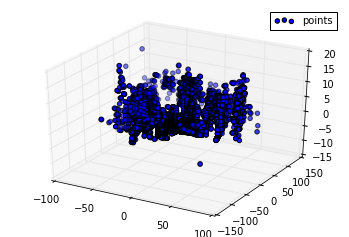

In [153]:
fig = plt.figure()
ax = fig.gca(projection='3d')

x = [0,8,15,3]
y = [4,23,6,17]
z = [8,0.9,10,11]
ax.scatter(pt_x, pt_y, pt_z, label='points')
#ax.scatter(x, y, z, label='points')
ax.legend()
#cv2.imshow('points', np.array([x,z])
plt.show()

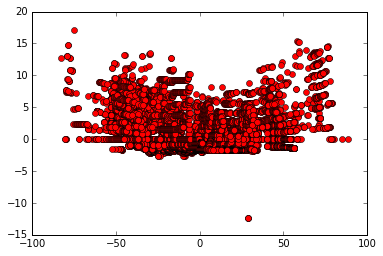

In [154]:
plt.plot(pt_x, pt_z, 'ro')
plt.show()


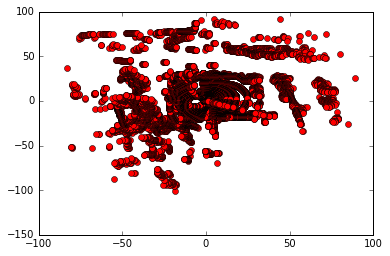

In [155]:
plt.plot(pt_x, pt_y, 'ro')
plt.show()